# Get images from visual sensor

In [2]:
%pylab inline
import sim
import numpy as np
from trajectory import min_snap_trajectory
from catenary_trajectoryC import trajectoryC

Populating the interactive namespace from numpy and matplotlib


In [3]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Quadricopter_target'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)  
    res, position = sim.simxGetObjectOrientation(clientID, cuboid, -1, sim.simx_opmode_blocking)  
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Connected
Simulation time in milliseconds:  2550
Omnirob is at [x,y,z]= [-0.0, 0.0, -0.0]
Disconnected


In [4]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)

    def get_orientation(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, euler = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(euler)    
     
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

In [5]:
import sim as vrep
import time
import cv2
import numpy as np

vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    res, R1 = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx', vrep.simx_opmode_oneshot_wait)
    
    
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)

    relative_object = -1
    res, euler = vrep.simxGetObjectOrientation(clientID, R1, relative_object, vrep.simx_opmode_blocking)        
       
    
    # Take p pictures
    p = 1
    i = 0
    img2 =  []
    angle = []
    
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        res, euler = vrep.simxGetObjectOrientation(clientID, R1, relative_object, vrep.simx_opmode_buffer)        
    
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            
            img2.append(img)
            angle.append(euler)
            
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(1)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Getting first image
image 0 OK!!!


True

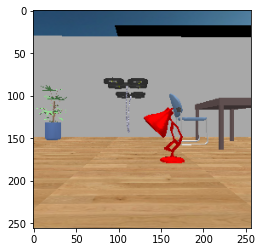

In [5]:

img = cv2.flip(img, 0)

imshow(img)


image2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Filename 
filename = 'savedImage.jpg'
  
# Using cv2.imwrite() method 
# Saving the image 
cv2.imwrite(filename, image2) 

In [6]:
def Rotz(Θ):
    R = array([[cos(Θ), -sin(Θ)], [sin(Θ), cos(Θ)]])
    return R

True

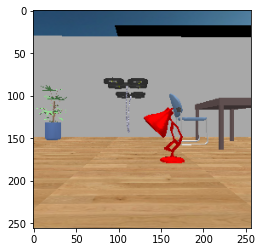

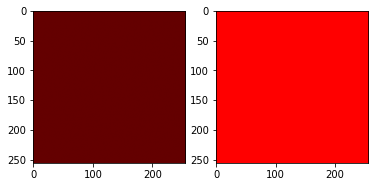

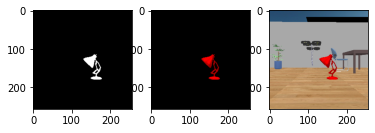

In [7]:
imshow(img)

light_orange = (100, 0, 0)
dark_orange = (255, 0, 0)

lo_square = np.full((256, 256, 3), light_orange, dtype=np.uint8) / 255.0
do_square = np.full((256, 256, 3), dark_orange, dtype=np.uint8) / 255.0

fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow((lo_square))
plt.subplot(1, 2, 2)
plt.imshow((do_square))

####
mask = cv2.inRange(img, light_orange, dark_orange)
result = cv2.bitwise_and(img, img, mask=mask)

fig = plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(result)
plt.subplot(1, 3, 3)
plt.imshow(img)


# Filename 
filename = 'savedImage2.jpg'
  
# Using cv2.imwrite() method 
# Saving the image 
image2 = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
cv2.imwrite(filename, image2) 

# Filename 
filename = 'savedImage3.jpg'
  
# Using cv2.imwrite() method 
# Saving the image 
# image2 = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
cv2.imwrite(filename, mask) 

In [12]:
r1 = robot('Quadricopter_target')
r2 = robot('Quadricopter_target#0')

cat = robot('C2')

tend = 4

p = r1.get_object_position('Sphere')
p1 = r1.get_object_position('Sphere1')
p3 = r1.get_object_position('Sphere3')
p4 = r1.get_object_position('Sphere4')
p5 = r1.get_object_position('Sphere5')

cat.set_position([0,0,0])


# p0 = [0.5,0,0.2]
# p1 = [0.3,0,0.5]
# p2 = [-0.3,0,0.5]
# p3 = [0,0,0.3]

wayptset =  np.array([p,p1,p3,p4,p5])
speed = tend

traj_vars = min_snap_trajectory(0, speed, None, waypts=wayptset)

# [pos, vel, acc, yaw, yawdot] = min_snap_trajectory(0, speed/2, traj_vars)
# [dst_xAd, dst_xBd, Yaw] = trajectoryC(0,pos,yaw,1,1.5)
# r1.set_position(dst_xBd)
# r2.set_position(dst_xAd)
# pause(10)

tend = 10
time_steps = linspace(0, tend, int((tend)/0.05))

for t in time_steps[:-2]:
    [pos, vel, acc, yaw, yawdot] = min_snap_trajectory(t, speed, traj_vars)
    [dst_xAd, dst_xBd, Yaw] = trajectoryC(0,pos,yaw,1,1.2)
#     print(pos,dst_xAd,dst_xBd)
    r1.set_position(dst_xBd)
    r2.set_position(dst_xAd)
    pause(1.5)

Robot connected
Robot connected
Robot connected
